Using optimization routines from `scipy` and `statsmodels`
====

In [1]:
import scipy.linalg as la

Finding roots
----

For root finding, we generally need to proivde a starting point in the vicinitiy of the root. For iD root finding, this is often provided as a bracket (a, b) where a and b have opposite signs.

### Univariate roots and fixed points

In [2]:
def f(x):
    return x**3-3*x+1

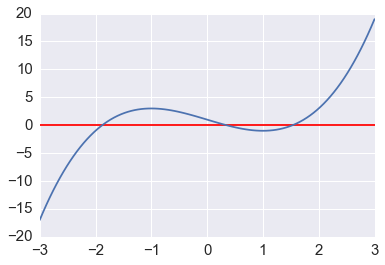

In [3]:
x = np.linspace(-3,3,100)
plt.axhline(0, c='red')
plt.plot(x, f(x));

In [4]:
from scipy.optimize import brentq, newton

#### `brentq` is the recommended method

In [5]:
brentq(f, -3, 0), brentq(f, 0, 1), brentq(f, 1,3)

(-1.8793852415718166, 0.3472963553337031, 1.532088886237956)

#### Secant method

In [6]:
newton(f, -3), newton(f, 0), newton(f, 3)

(-1.8793852415718169, 0.34729635533385395, 1.5320888862379578)

#### Newton-Raphson method

In [7]:
fprime = lambda x: 3*x**2 - 3
newton(f, -3, fprime), newton(f, 0, fprime), newton(f, 3, fprime)

(-1.8793852415718166, 0.34729635533386066, 1.532088886237956)

#### Analytical solution using `sympy` to find roots of a polynomial

In [8]:
from sympy import symbols, N, real_roots

In [9]:
x = symbols('x', real=True)
sol = real_roots(x**3 - 3*x + 1)
list(map(N, sol))

[-1.87938524157182, 0.347296355333861, 1.53208888623796]

#### Finding fixed points

Finding the fixed points of a function $g(x) = x$ is the same as finding the roots of $g(x) - x$. However, specialized algorihtms also exist - e.g. using `scipy.optimize.fixedpoint`.

In [10]:
from scipy.optimize import fixed_point

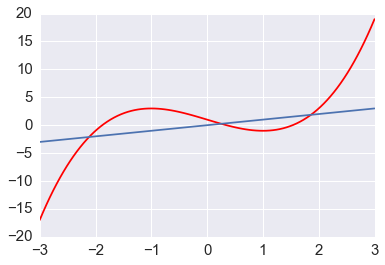

In [11]:
x = np.linspace(-3,3,100)
plt.plot(x, f(x), color='red')
plt.plot(x, x)
pass

In [12]:
fixed_point(f, 0), fixed_point(f, -3), fixed_point(f, 3)

(0.2541016883650524, -2.114907541476756, 1.8608058531117035)

In [13]:
newton(lambda x: f(x) - x, 0), newton(lambda x: f(x) - x, -3), newton(lambda x: f(x) - x, 3)

(0.2541016883650524, -2.114907541476814, 1.8608058531117062)

In [14]:
def f(x, r):
    """Discrete logistic equation."""
    return r*x*(1-x)

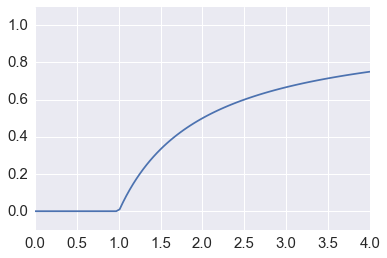

In [15]:
n = 100
fps = np.zeros(n)
for i, r in enumerate(np.linspace(0, 4, n)):
    fps[i] = fixed_point(f, 0.5, args=(r, ))

plt.plot(np.linspace(0, 4, n), fps)
plt.axis([0,4,-0.1, 1.1])
pass

#### Note that we don't know anything about the **stability** of the fixed point

Beyond $r = 3$, the fixed point is unstable, even chaotic, but we would never know that just from the plot above.

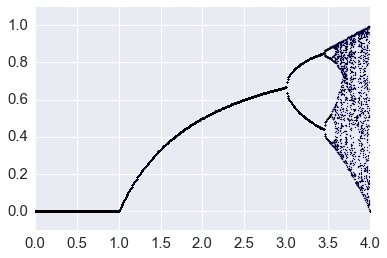

In [16]:
xs = []
for i, r in enumerate(np.linspace(0, 4, 400)):
    x = 0.5
    for j in range(10000):
        x = f(x, r)
    for j in range(50):
        x = f(x, r)
        xs.append((r, x))
xs = np.array(xs)
plt.scatter(xs[:,0], xs[:,1], s=1)
plt.axis([0,4,-0.1, 1.1])
pass

### Mutlivariate roots and fixed points

Use `root` to solve polynomial euqations. Use `fsolve` for non-polynomial equations.

In [17]:
from scipy.optimize import root, fsolve

Suppose we want to solve a sysetm of $m$ equations with $n$ unknowns

\begin{align}
f(x_0, x_1) &= x_1 - 3x_0(x_0+1)(x_0-1) \\
g(x_0, x_1) &= 0.25 x_0^2 + x_1^2 - 1
\end{align}

In [18]:
def f(x):
    return [x[1] - 3*x[0]*(x[0]+1)*(x[0]-1),
            .25*x[0]**2 + x[1]**2 - 1]

In [19]:
sol = root(f, (0.5, 0.5))
sol.x

array([ 1.11694147,  0.82952422])

In [20]:
fsolve(f, (0.5, 0.5))

array([ 1.11694147,  0.82952422])

#### We can also give the jacobian

In [21]:
def jac(x):
    return [[-6*x[0], 1], [0.5*x[0], 2*x[1]]]

In [22]:
sol = root(f, (0.5, 0.5), jac=jac)
sol.x, sol.fun

(array([ 1.11694147,  0.82952422]),
 array([ -4.23383550e-12,  -3.31612515e-12]))

#### Check that values found are really roots

In [23]:
np.allclose(f(sol.x), 0)

True

#### Starting from other initial conditions, different roots may be found

In [24]:
sol = root(f, (12,12))
sol.x

array([ 0.77801314, -0.92123498])

In [25]:
np.allclose(f(sol.x), 0)

True

Optimization Primer
----

We will assume that our optimization problem is to minimize some univariate or multivariate function $f(x)$. This is without loss of generality, since to find the maximum, we can simply minime $-f(x)$. We will also assume that we are dealing with multivariate or real-valued smooth functions - non-smooth or discrete functions (e.g. integer-valued) are outside the scope of this course.

To find the minimum of a function, we first need to be able to express the function as a mathemtical expresssion. For example, in lesst squares regression, the function that we are optimizing is of the form $y_i - f(x_i, \theta)$ for some parameter(s) $\theta$. To choose an appropirate optimization algorihtm, we should at least answr these two questions if possible:

1. Is the function convex?
2. Are there any constraints that the solution must meet?

Finally, we need to realize that optimization mehthods are nearly always designed to find local optima. For convex problems, there is only one minimum and so this is not a problem. However, if there are multiple local minima, often heuristics such as multiple random starts must be adopted to find a "good" enouhg solution. 

### Is the function convex?

Convex functions are very nice because they have a **single global minimum**, and there are very efficient algorithms for solving large convex systems. 

Intuitively, a function is convex if every chord joining two points on the function lies above the function. More formally, a function is convex if 
$$
f(ta + (1-t)b) \lt tf(a) + (1-t)f(b)
$$ 
for some $t$ between 0 and 1 - this is shown in the figure below.

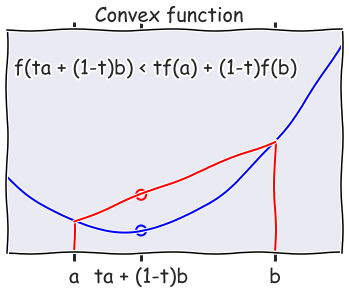

In [26]:
def f(x):
    return (x-4)**2 + x + 1

with plt.xkcd():
    x = np.linspace(0, 10, 100)

    plt.plot(x, f(x))
    ymin, ymax = plt.ylim()
    plt.axvline(2, ymin, f(2)/ymax, c='red')
    plt.axvline(8, ymin, f(8)/ymax, c='red')
    plt.scatter([4, 4], [f(4), f(2) + ((4-2)/(8-2.))*(f(8)-f(2))], 
                 edgecolor=['blue', 'red'], facecolor='none', s=100, linewidth=2)
    plt.plot([2,8], [f(2), f(8)])
    plt.xticks([2,4,8], ('a', 'ta + (1-t)b', 'b'), fontsize=20)
    plt.text(0.2, 40, 'f(ta + (1-t)b) < tf(a) + (1-t)f(b)', fontsize=20)
    plt.xlim([0,10])
    plt.yticks([])
    plt.suptitle('Convex function', fontsize=20)

#### Warm up exercise

Show that $f(x)  = -\log(x)$ is a convex function.

#### Checking if a function is convex using the Hessian

The formal definition is only useful for checking if a function is convex if you can find a counter-example. More practically, a twice differentiable function is convex if its Hessian is positive semi-definite, and strictly convex if the Hessian is positive definite.

For example, suppose we want to minimize the scalar-valued function

$$
f(x_1, x_2, x_3) = x_1^2 + 2x_2^2 + 3x_3^2 + 2x_1x_2 + 2x_1x_3
$$

In [27]:
from sympy import symbols, hessian, Function, init_printing, expand, Matrix, diff
x, y, z = symbols('x y z')
f = symbols('f', cls=Function)
init_printing()

In [28]:
f = x**2 + 2*y**2 + 3*z**2 + 2*x*y + 2*x*z
f

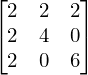

In [29]:
H = hessian(f, (x, y, z))
H

In [30]:
np.real_if_close(la.eigvals(np.array(H).astype('float')))

array([ 0.24122952,  7.06417777,  4.69459271])

Since the matrix is symmetric and all eigenvalues are positive, the Hessian is positive defintie and the function is convex.

#### Combining convex functions

The following rules may be useful to determine if more complex functions are covex:

1. The intersection of convex functions is convex
2. If the functions $f$ and $g$ are convex and $a \ge 0$ and $b \ge 0$ then the function $af + bg$ is convex.
3. If the function $U$ is convex and the function $g$ is nondecreasing and convex then the function  f  defined by $f (x) = g(U(x))$ is convex.

Many more technical deetails about convexity and convex optimization can be found in this [book](http://web.stanford.edu/~boyd/cvxbook/).

### Are there any constraints that the solution must meet?

In general, optimizaiton without constraints is easier to solve than optimization in the presence of constraints. In any case, the solutions may be very different in the prsence or absence of constraints, so it is important to know if there are any constraints.

We will see some examples of two general strategies - convert a problme with constraints into one without constraints, or use an algorithm that can optimize with constraints.

Using `scipy.optimize`
----

One of the most convenient libraries to use is `scipy.optimize`, since it is already part of the Anaconda installation and it has a fairly intuitive interface.

In [31]:
from scipy import optimize as opt

#### Minimizing a univariate function $f: \mathbb{R} \rightarrow \mathbb{R}$

In [32]:
def f(x):
    return x**4 + 3*(x-2)**3 - 15*(x)**2 + 1

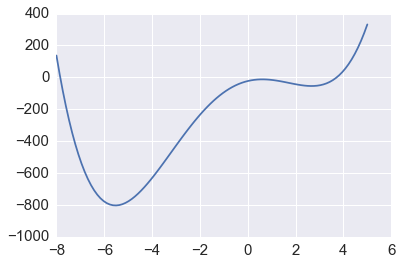

In [33]:
x = np.linspace(-8, 5, 100)
plt.plot(x, f(x));

The [`minimize_scalar`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html#scipy.optimize.minimize_scalar) function will find the minimum, and can also be told to search within given bounds. By default, it uses the Brent algorithm, which combines a bracketing strategy with a parabolic approximation.

In [34]:
opt.minimize_scalar(f, method='Brent')

  nit: 11
 nfev: 12
    x: -5.5288011252196627
  fun: -803.39553088258845

In [35]:
opt.minimize_scalar(f, method='bounded', bounds=[0, 6])

    nfev: 12
 success: True
     fun: -54.210039377127622
  status: 0
 message: 'Solution found.'
       x: 2.6688651040396532

### Local and global minima

In [36]:
def f(x, offset):
    return -np.sinc(x-offset)

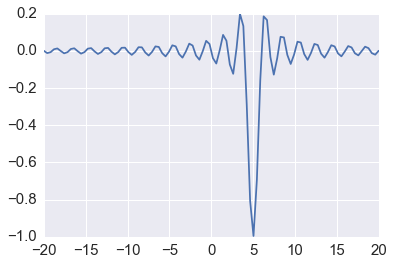

In [37]:
x = np.linspace(-20, 20, 100)
plt.plot(x, f(x, 5));

In [38]:
# note how additional function arguments are passed in
sol = opt.minimize_scalar(f, args=(5,))
sol

  nit: 10
 nfev: 11
    x: -1.4843871263953001
  fun: -0.049029624014074166

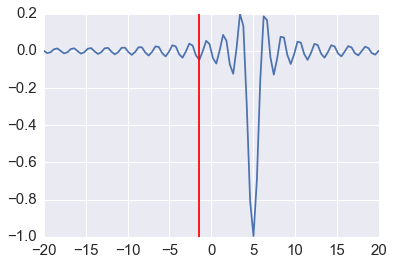

In [39]:
plt.plot(x, f(x, 5))
plt.axvline(sol.x, c='red')
pass

#### We can try multiple ranodm starts to find the global minimum

In [40]:
lower = np.random.uniform(-20, 20, 100)
upper = lower + 1
sols = [opt.minimize_scalar(f, args=(5,), bracket=(l, u)) for (l, u) in zip(lower, upper)]

In [41]:
idx = np.argmin([sol.fun for sol in sols])
sol = sols[idx]

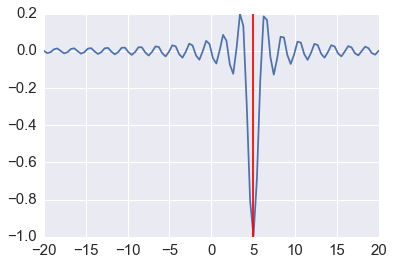

In [42]:
plt.plot(x, f(x, 5))
plt.axvline(sol.x, c='red');

#### Using a stochastic algorithm

See documentation for the [`basinhopping`](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.basinhopping.html) algorithm, which also works with multivariate scalar optimization. Note that this is heuristic and not guaranteed to find a global minimum.

In [43]:
from scipy.optimize import basinhopping

x0 = 0
sol = basinhopping(f, x0, stepsize=1, minimizer_kwargs={'args': (5,)})
sol

                  nfev: 1812
                  njev: 604
                   fun: -1.0
                   nit: 100
               message: ['requested number of basinhopping iterations completed successfully']
                     x: array([ 5.])
 minimization_failures: 0

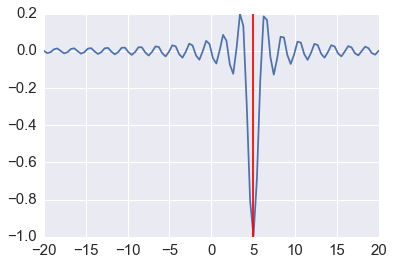

In [44]:
plt.plot(x, f(x, 5))
plt.axvline(sol.x, c='red');

#### Minimizing a multivariate function $f: \mathbb{R}^n \rightarrow \mathbb{R}$

We will next move on to optimization of multivariate scalar functions, where the scalar may (say) be the norm of a vector. Minimizing a multivariable set of equations $f: \mathbb{R}^n \rightarrow \mathbb{R}$^n$ is not well-defined, but we will later see how to solve the closely related problme of finding roots or fixed points of such a set of equations.

We will use the [Rosenbrock "banana" function](http://en.wikipedia.org/wiki/Rosenbrock_function) to illustrate unconstrained multivariate optimization. In 2D, this is
$$
f(x, y) = b(y - x^2)^2 + (a - x)^2
$$

The function has a global minimum at (1,1) and the standard expression takes $a = 1$ and $b = 100$. 

#### Conditioning of optimization problem

With these values fr $a$ and $b$, the problem is ill-conditioned. As we shall see, one of the factors affecting the ease of optimization is the condition number of the curvature (Hessian). When the condition number is high, the gradient may not point in the direction of the minimum, and simple gradient descent methods may be inefficient since they may be forced to take many sharp turns.

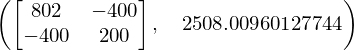

In [45]:
from sympy import symbols, hessian, Function, N

x, y = symbols('x y')
f = symbols('f', cls=Function)

f = 100*(y - x**2)**2 + (1 - x)**2

H = hessian(f, [x, y]).subs([(x,1), (y,1)])
H, N(H.condition_number())

#### As pointed out in the previous lecture, the condition number is basically the ratio of largest to smallest eigenvalue of the Hessian

In [46]:
import scipy.linalg as la

mu = la.eigvals(np.array([802, -400, -400, 200]).reshape((2,2)))
np.real_if_close(mu[0]/mu[1])

array(2508.009601277337)

In [47]:
def rosen(x):
    """Generalized n-dimensional version of the Rosenbrock function"""
    return sum(100*(x[1:]-x[:-1]**2.0)**2.0 +(1-x[:-1])**2.0)

#### Why is the condition number so large?

In [48]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))

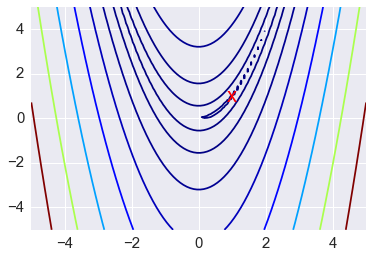

In [49]:
# Note: the global minimum is at (1,1) in a tiny contour island
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.text(1, 1, 'x', va='center', ha='center', color='red', fontsize=20);

#### Zooming in to the global minimum at (1,1)

In [50]:
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))

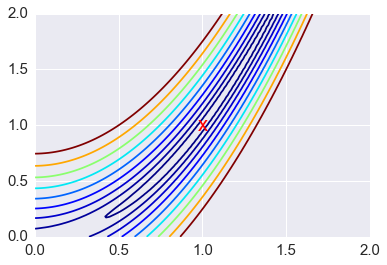

In [51]:
plt.contour(X, Y, Z, [rosen(np.array([k, k])) for k in np.linspace(1, 1.5, 10)], cmap='jet')
plt.text(1, 1, 'x', va='center', ha='center', color='red', fontsize=20);

Gradient descent
----

The gradient (or Jacobian) at a point indicates the direction of steepest ascent. Since we are looking for a minimum, one obvious possibility is to take a step in the opposite direction to the gradient. We weight the size of the step by a factor $\alpha$ known in the machine learning literature as the learning rate. If $\alpha$ is small, the algorithm will eventually converge towards a local minimum, but it may take long time. If $\alpha$ is large, the algorithm may converge faster, but it may also overshoot and never find the minimum. Gradient descent is also known as a first order method because it requires calculation of the first derivative at each iteration.

Some algorithms also determine the appropriate value of $\alpha$ at each stage by using a line search, i.e.,
$$
\alpha^* = \arg\min_\alpha f(x_k - \alpha \nabla{f(x_k)})
$$
which is a 1D optimization problem.

As suggested above, the problem is that the gradient may not point towards the global minimum especially when the condition number is large, and we are forced to use a small $\alpha$ for convergence. 

#### Simple gradient descent

Let's warm up by minimizing a trivial function $f(x, y) = x^2 + y^2$ to illustrate the basic idea of gradient descent.

In [54]:
def f(x):
    return x[0]**2 + x[1]**2

def grad(x):
    return np.array([2*x[0], 2*x[1]])

a = 0.1 # learning rate
x0 = np.array([1.0,1.0])
print('Start', x0)
for i in range(41):
    x0 -= a * grad(x0)
    if i%5 == 0:
        print(i, x0)

Start [ 1.  1.]
0 [ 0.8  0.8]
5 [ 0.262144  0.262144]
10 [ 0.08589935  0.08589935]
15 [ 0.0281475  0.0281475]
20 [ 0.00922337  0.00922337]
25 [ 0.00302231  0.00302231]
30 [ 0.00099035  0.00099035]
35 [ 0.00032452  0.00032452]
40 [ 0.00010634  0.00010634]


### Gradient descent for least squares minimization

Usually, when we optimize, we are not just finding the minimum, but also want to know the parameters that give us the minimum. As a simple example, suppose we want to find parameters that minimize the least squares difference between a linear model and some data.  Suppose we have some data $(0,1), (1,2), (2,3), (3,3.5), (4,6), (5,9), (6,8)$ and want to find a line $y = \beta_0  +\beta_1 x$ that is the best least squares fit. One way to do this is to solve $X^TX\hat{\beta} = X^Ty$, but we want to show how this can be formulated as a gradient descent problem.

We want to find $\beta = (\beta_0, \beta_1)$ that minimize the squared differences

$$
r = \sum(\beta_0 + \beta_1 x - y)^2
$$

We calculate the gradient with respect to $\beta$ as 

$$\nabla r = \pmatrix{ \frac{\delta r}{\delta \beta_0} \\ \frac{\delta r}{\delta \beta_0}}$$

and apply gradient descent.

In [13]:
def f(x, y, b):
    """Helper function."""
    return (b[0] + b[1]*x - y)

def grad(x, y, b):
    """Gradient of objective function with respect to parameters b."""
    n = len(x)
    return np.array([
            sum(f(x, y, b)),
            sum(x*f(x, y, b))
    ])

In [10]:
x, y = map(np.array, zip((0,1), (1,2), (2,3), (3,3.5), (4,6), (5,9), (6,8)))

In [16]:
a = 0.001 # learning rate
b0 = np.zeros(2)
for i in range(10000):
    b0 -= a * grad(x, y, b0)

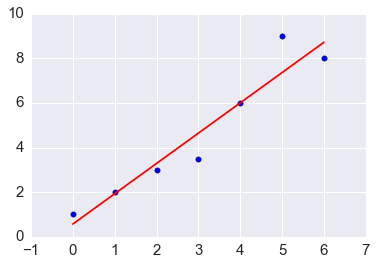

In [17]:
plt.scatter(x, y, s=30)
plt.plot(x, b0[0] + b0[1]*x, color='red')
pass

### Gradient descent to minimize the Rosen function using `scipy.optimize`

Because gradient descent is unreliable in practice, it is not part of the `scipy` optimize suite of functions, but we will write a custom function below to illustrate how to use gradient descent while maintaining the `scipy.optimize` interface.

In [52]:
def rosen_der(x):
    """Derivative of generalized Rosen function."""
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return der

**Warning** One of the most common causes of failure of optimization is because the gradient  or Hessian function is specified incorrectly. You can check for this using `check_grad` which compares the analytical gradient with one calculated using finite differences.

In [53]:
from scipy.optimize import check_grad

for x in np.random.uniform(-2,2,(10,2)):
    x0 = np.array(x)
    print(x0, check_grad(rosen, rosen_der, x0))

[ 0.84795961  0.8841431 ] 4.12099762158e-06
[ 0.25702089  1.12043717] 2.22491327726e-06
[ 1.06226702 -1.80970275] 3.12407324679e-05
[ 1.5334192 -1.5059954] 1.13208298556e-05
[-0.15930274  1.80868951] 3.71611303963e-06
[ 1.32643444 -1.18424149] 3.25553261955e-05
[ 0.49184844 -0.00341954] 2.67781137655e-06
[ 0.85557139  1.12996825] 3.31235322885e-06
[-1.00825153 -1.85587153] 1.62466187316e-05
[ 0.41514196  0.6850504 ] 1.7634932791e-06


#### Writing a custom function for the `scipy.optimize` interface.

In [55]:
def custmin(fun, x0, args=(), maxfev=None, alpha=0.0002,
        maxiter=100000, tol=1e-10, callback=None, **options):
    """Implements simple gradient descent for the Rosen function."""
    bestx = x0
    besty = fun(x0)
    funcalls = 1
    niter = 0
    improved = True
    stop = False

    while improved and not stop and niter < maxiter:
        niter += 1
        # the next 2 lines are gradient descent
        step = alpha * rosen_der(bestx)
        bestx = bestx - step

        besty = fun(bestx)
        funcalls += 1
        
        if la.norm(step) < tol:
            improved = False
        if callback is not None:
            callback(bestx)
        if maxfev is not None and funcalls >= maxfev:
            stop = True
            break

    return opt.OptimizeResult(fun=besty, x=bestx, nit=niter,
                              nfev=funcalls, success=(niter > 1))

In [56]:
def reporter(p):
    """Reporter function to capture intermediate states of optimization."""
    global ps
    ps.append(p)

In [57]:
# Initial starting position
x0 = np.array([4,-4.1])

In [58]:
ps = [x0]
opt.minimize(rosen, x0, method=custmin, callback=reporter)

     nit: 100000
 success: True
    nfev: 100001
       x: array([ 0.9998971 ,  0.99979381])
     fun: 1.0604663473448339e-08

In [59]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = rosen(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))

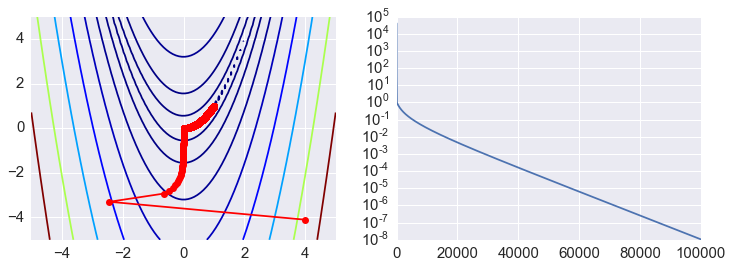

In [60]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.plot(ps[:, 0], ps[:, 1], '-ro')
plt.subplot(122)
plt.semilogy(range(len(ps)), rosen(ps.T));

### Newton's method and variants

Recall Newton's method for finding roots of a univariate function

$$
x_{K+1} = x_k - \frac{f(x_k)}{f'(x_k)}
$$

When we are looking for a minimum, we are looking for the roots of the *derivative* $f'(x)$, so

$$
x_{K+1} = x_k - \frac{f'(x_k}{f''(x_k)}
$$

Newotn's method can also be seen as a Taylor series approximation

$$
f(x+h) = f(x) + h f'(x) + \frac{h^2}{2}f''(x)
$$

At the function minimum, the derivtive is 0, so
\begin{align}
\frac{f(x+h) - f(x)}{h} &= f'(x) + \frac{h}{2}f''(x) \\
0 &= f'(x) + \frac{h}{2}f''(x) 
\end{align}

and letting $\Delta x = \frac{h}{2}$, we get that the Newton stpe is

$$
\Delta x = - \frac{f'(x)}{f''(x)}
$$

The multivariate analog replaces $f'$ with the Jacobian and $f''$ with the Hessian, so the Newton step is

$$
\Delta x = -H^{-1}(x) \nabla f(x)
$$

#### Second order methods

Second order methods solve for $H^{-1}$ and so require calculation of the Hessian (either provided or approximated using finite differences). For efficiency reasons, the Hessian is not directly inverted, but solved for using a variety of methods such as conjugate gradient. An example of a second order method in the `optimize` package is `Newton-GC`.

In [61]:
from scipy.optimize import rosen, rosen_der, rosen_hess

In [62]:
ps = [x0]
opt.minimize(rosen, x0, method='Newton-CG', jac=rosen_der, hess=rosen_hess, callback=reporter)

 success: True
    nfev: 38
     fun: 1.3642782750354208e-13
     nit: 26
    njev: 63
    nhev: 26
  status: 0
 message: 'Optimization terminated successfully.'
       x: array([ 0.99999963,  0.99999926])
     jac: array([  1.21204353e-04,  -6.08502470e-05])

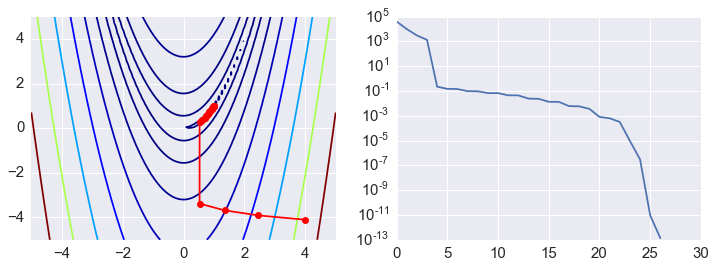

In [63]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.plot(ps[:, 0], ps[:, 1], '-ro')
plt.subplot(122)
plt.semilogy(range(len(ps)), rosen(ps.T));

#### Frist order methods

As calculating the Hessian is computationally expensive, first order methods only use the first derivatives. Quasi-Newton methods use functions of the first derivatives to approximate the inverse Hessian. A well know example of the Quasi-Newoton class of algorithjms is BFGS, named after the initials of the creators. As usual, the first derivatives can either be provided via the `jac=` argument or approximated by finite difference methods.

In [64]:
ps = [x0]
opt.minimize(rosen, x0, method='BFGS', callback=reporter)

     nfev: 280
 hess_inv: array([[ 0.49982388,  0.99958969],
       [ 0.99958969,  2.00405492]])
      fun: 1.2055799758407391e-11
      nit: 44
     njev: 67
  success: False
   status: 2
  message: 'Desired error not necessarily achieved due to precision loss.'
        x: array([ 0.99999659,  0.99999311])
      jac: array([  2.46198954e-05,  -1.12454678e-05])

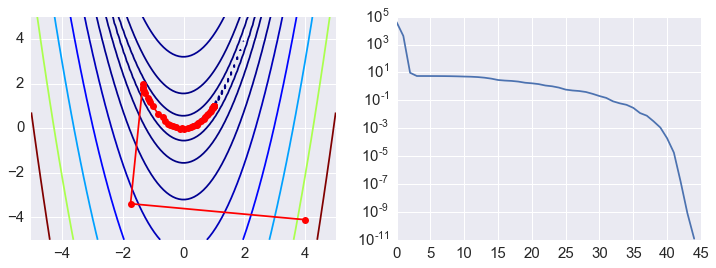

In [65]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.plot(ps[:, 0], ps[:, 1], '-ro')
plt.subplot(122)
plt.semilogy(range(len(ps)), rosen(ps.T));

#### Zeroth order methods

Finally, there are some optimization algorithms not based on the Newton method, but on other heuristic search strategies that do not require any derivatives, only function evaluations. One well-known example is the Nelder-Mead simplex algorithm.

In [66]:
ps = [x0]
opt.minimize(rosen, x0, method='nelder-mead', callback=reporter)

    nfev: 162
 success: True
  status: 0
     fun: 5.262756878429089e-10
     nit: 85
 message: 'Optimization terminated successfully.'
       x: array([ 0.99998846,  0.99997494])

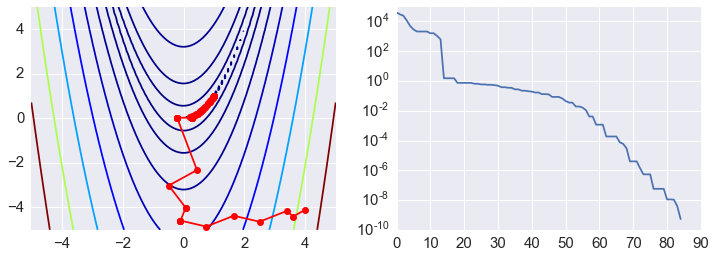

In [67]:
ps = np.array(ps)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.contour(X, Y, Z, np.arange(10)**5, cmap='jet')
plt.plot(ps[:, 0], ps[:, 1], '-ro')
plt.subplot(122)
plt.semilogy(range(len(ps)), rosen(ps.T));

### Lagrange multipliers and constrained optimization

Recall why Lagrange multipliers are useful for constrained optimization - a stationary point must be where the constraint surface $g$ touches a level set of the function $f$ (since the value of $f$ does not change on a level set). At that point, $f$ and $g$ are parallel, and hence their gradients are also parallel (since the gradient is normal to the level set). So we want to solve

$$\nabla f = -\lambda \nabla g$$

or equivalently,

$$\nabla f + \lambda \nabla g = 0$$

![Lagrange multipliers](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/LagrangeMultipliers2D.svg/300px-LagrangeMultipliers2D.svg.png)

#### Numerical example of using Lagrange multipliers

Maximize $f (x, y, z) = xy + yz$ subject to the constraints $x + 2y = 6$ and $x − 3z = 0$.

We set up the equations

$$
F (x, y, z, λ, μ) = xy + yz − λ(x + 2y − 6) − μ(x − 3z)
$$

Now set partial derivatives to zero and solve the following set of equations

\begin{align}
y - \lambda - \mu &= 0 \\
x + z - 2\lambda &= 0 \\
y +3\mu &= 0 \\
x + 2y - 6 &= 0 \\
x - 3z &= 0
\end{align}

which is a linear equation in $x, y, z, \lambda, \mu$

$$
\begin{pmatrix}
0 & 1 & 0 & -1 & -1 \\
1 & 0 & 1 & -2 & 0 \\
0 & 1 & 0 & 0 & 3 \\
1 & 2 & 0 & 0 & 0 \\
1 & 0 & -3 & 0 & 0 \\
\end{pmatrix}\pmatrix{x \\ y \\ z \\ \lambda \\ \mu} = \pmatrix{0 \\ 0 \\ 0 \\ 6 \\ 0}
$$

In [68]:
A = np.array([
    [0, 1, 0, -1, -1],
    [1, 0, 1, -2, 0],
    [0, 1, 0, 0, 3],
    [1, 2, 0, 0, 0],
    [1, 0,-3, 0, 0]])

b = np.array([0,0,0,6,0])

sol = la.solve(A, b)

In [69]:
sol

array([ 3. ,  1.5,  1. ,  2. , -0.5])

In [70]:
def f(x, y, z):
    return x*y + y*z

In [71]:
f(*sol[:3])

### Check using `scipy.optimize`

In [72]:
# Convert to minimization problem by negating function
def f(x):
    return -(x[0]*x[1] + x[1]*x[2])

In [73]:
cons = ({'type': 'eq',
         'fun' : lambda x: np.array([x[0] + 2*x[1] - 6, x[0] - 3*x[2]])})

In [74]:
x0 = np.array([2,2,0.67])
cx = opt.minimize(f, x0, constraints=cons)
cx

    nfev: 15
     fun: -5.9999999999999689
     nit: 3
    njev: 3
 success: True
  status: 0
 message: 'Optimization terminated successfully.'
       x: array([ 2.99999979,  1.50000011,  0.99999993])
     jac: array([-1.50000012, -3.9999997 , -1.50000012,  0.        ])

### Another example of constrained optimization

Many real-world optimization problems have constraints - for example, a set of parameters may have to sum to 1.0 (equality constraint), or some parameters may have to be non-negative (inequality constraint). Sometimes, the constraints can be incorporated into the function to be minimized, for example, the non-negativity constraint $p \gt 0$ can be removed by substituting $p = e^q$ and optimizing for $q$. Using such workarounds, it may be possible to convert a constrained optimization problem into an unconstrained one, and use the methods discussed above to solve the problem.

Alternatively, we can use optimization methods that allow the specification of constraints directly in the problem statement as shown in this section. Internally, constraint violation penalties, barriers and Lagrange multipliers are some of the methods used used to handle these constraints. We use the example provided in the Scipy [tutorial](http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html) to illustrate how to set constraints.

$$
f(x) = -(2xy + 2x - x^2 -2y^2)
$$
subject to the constraint
$$
x^3 - y = 0 \\
y - (x-1)^4 - 2 \ge 0
$$
and the bounds
$$
0.5 \le x \le 1.5 \\
1.5 \le y \le 2.5
$$

In [75]:
def f(x):
    return -(2*x[0]*x[1] + 2*x[0] - x[0]**2 - 2*x[1]**2)

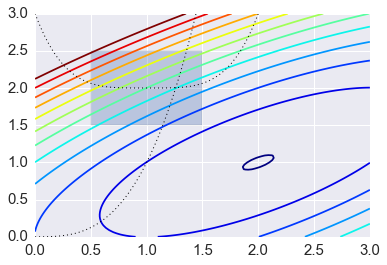

In [76]:
x = np.linspace(0, 3, 100)
y = np.linspace(0, 3, 100)
X, Y = np.meshgrid(x, y)
Z = f(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
plt.contour(X, Y, Z, np.arange(-1.99,10, 1), cmap='jet');
plt.plot(x, x**3, 'k:', linewidth=1)
plt.plot(x, (x-1)**4+2, 'k:', linewidth=1)
plt.fill([0.5,0.5,1.5,1.5], [2.5,1.5,1.5,2.5], alpha=0.3)
plt.axis([0,3,0,3])

To set constraints, we pass in a dictionary with keys `ty;pe`, `fun` and `jac`. Note that the inequality constraint assumes a $C_j x \ge 0$ form. As usual, the `jac` is optional and will be numerically estimate if not provided.

In [77]:
cons = ({'type': 'eq',
         'fun' : lambda x: np.array([x[0]**3 - x[1]]),
         'jac' : lambda x: np.array([3.0*(x[0]**2.0), -1.0])},
        {'type': 'ineq',
         'fun' : lambda x: np.array([x[1] - (x[0]-1)**4 - 2])})

bnds = ((0.5, 1.5), (1.5, 2.5))

In [78]:
x0 = [0, 2.5]

Unconstrained optimization

In [79]:
ux = opt.minimize(f, x0, constraints=None)
ux

     nfev: 20
 hess_inv: array([[ 0.99999996,  0.49999996],
       [ 0.49999996,  0.49999997]])
      fun: -1.9999999999999987
      nit: 3
     njev: 5
  success: True
   status: 0
  message: 'Optimization terminated successfully.'
        x: array([ 1.99999996,  0.99999996])
      jac: array([ 0.,  0.])

Constrained optimization

In [80]:
cx = opt.minimize(f, x0, bounds=bnds, constraints=cons)
cx

    nfev: 21
     fun: 2.0499154720925521
     nit: 5
    njev: 5
 success: True
  status: 0
 message: 'Optimization terminated successfully.'
       x: array([ 1.26089314,  2.00463288])
     jac: array([-3.48747873,  5.49674428,  0.        ])

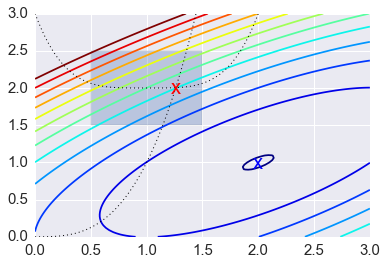

In [81]:
x = np.linspace(0, 3, 100)
y = np.linspace(0, 3, 100)
X, Y = np.meshgrid(x, y)
Z = f(np.vstack([X.ravel(), Y.ravel()])).reshape((100,100))
plt.contour(X, Y, Z, np.arange(-1.99,10, 1), cmap='jet');
plt.plot(x, x**3, 'k:', linewidth=1)
plt.plot(x, (x-1)**4+2, 'k:', linewidth=1)
plt.text(ux['x'][0], ux['x'][1], 'x', va='center', ha='center', size=20, color='blue')
plt.text(cx['x'][0], cx['x'][1], 'x', va='center', ha='center', size=20, color='red')
plt.fill([0.5,0.5,1.5,1.5], [2.5,1.5,1.5,2.5], alpha=0.3)
plt.axis([0,3,0,3]);

### Some applications of optimization

#### Curve fitting

Sometimes, we simply want to use non-linear least squares to fit a function to data, perhaps to estimate parameters for a mechanistic or phenomenological model. The `curve_fit` function uses the quasi-Newton Levenberg-Marquadt algorithm to perform such fits. Behind the scenes, `curve_fit` is just a wrapper around the `leastsq` function that does nonlinear least squares fitting.

In [82]:
from scipy.optimize import curve_fit 

In [83]:
def logistic4(x, a, b, c, d):
    """The four paramter logistic function is often used to fit dose-response relationships."""
    return ((a-d)/(1.0+((x/c)**b))) + d

In [84]:
nobs = 24
xdata = np.linspace(0.5, 3.5, nobs)
ptrue = [10, 3, 1.5, 12]
ydata = logistic4(xdata, *ptrue) + 0.5*np.random.random(nobs)

In [85]:
popt, pcov = curve_fit(logistic4, xdata, ydata) 

In [86]:
perr = yerr=np.sqrt(np.diag(pcov))
print('Param\tTrue\tEstim (+/- 1 SD)')
for p, pt, po, pe  in zip('abcd', ptrue, popt, perr):
    print('%s\t%5.2f\t%5.2f (+/-%5.2f)' % (p, pt, po, pe))

Param	True	Estim (+/- 1 SD)
a	10.00	10.38 (+/- 0.09)
b	 3.00	 4.04 (+/- 0.77)
c	 1.50	 1.47 (+/- 0.07)
d	12.00	12.08 (+/- 0.08)


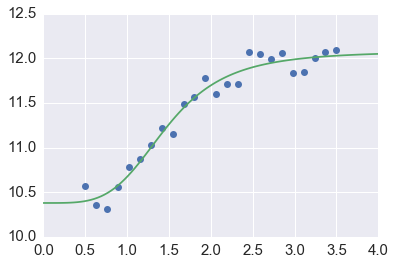

In [87]:
x = np.linspace(0, 4, 100)
y = logistic4(x, *popt)
plt.plot(xdata, ydata, 'o')
plt.plot(x, y);

### Finding paraemeters for ODE models

This is a specialized application of `curve_fit`, in which the curve to be fitted is defined implicitly by an ordinary differential equation 
$$
\frac{dx}{dt} = -kx
$$
and we want to use observed data to estimate the parameters $k$ and the initial value $x_0$. Of course this can be explicitly solved but the same approach can be used to find multiple parameters for $n$-dimensional systems of ODEs.

[A more elaborate example for fitting a system of ODEs to model the zombie apocalypse](http://adventuresinpython.blogspot.com/2012/08/fitting-differential-equation-system-to.html)

In [88]:
from scipy.integrate import odeint

def f(x, t, k):
    """Simple exponential decay."""
    return -k*x

def x(t, k, x0):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(f, x0, t, args=(k,))
    return x.ravel()

In [89]:
# True parameter values
x0_ = 10
k_ = 0.1*np.pi

# Some random data genererated from closed form soltuion plus Gaussian noise
ts = np.sort(np.random.uniform(0, 10, 200))
xs = x0_*np.exp(-k_*ts) + np.random.normal(0,0.1,200)

popt, cov = curve_fit(x, ts, xs)
k_opt, x0_opt = popt

print("k = %g" % k_opt)
print("x0 = %g" % x0_opt)

k = 0.313004
x0 = 9.88547


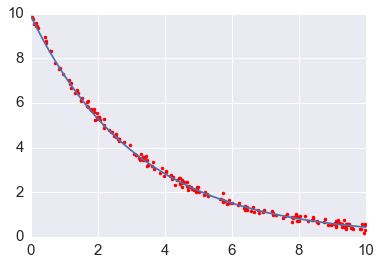

In [90]:
import matplotlib.pyplot as plt
t = np.linspace(0, 10, 100)
plt.plot(ts, xs, 'r.', t, x(t, k_opt, x0_opt), '-');

### Another example of fitting a system of ODEs using the `lmfit` package

You may have to install the [`lmfit`](http://cars9.uchicago.edu/software/python/lmfit/index.html) package using `pip` and restart your kernel. The `lmfit` algorithm is another wrapper around `scipy.optimize.leastsq` but allows for richer model specification and more diagnostics.

In [91]:
from lmfit import minimize, Parameters, Parameter, report_fit
import warnings

[[Fit Statistics]]
    # function evals   = 169
    # data points      = 200
    # variables        = 6
    chi-square         = 212.716
    reduced chi-square = 1.096
[[Variables]]
    x0:   1.02052198 +/- 0.181683 (17.80%) (init= 0)
    y0:   1.07046508 +/- 0.110177 (10.29%) (init= 1.997345)
    a:    3.54341848 +/- 0.454160 (12.82%) (init= 2)
    b:    1.21280681 +/- 0.148475 (12.24%) (init= 2)
    c:    0.84529664 +/- 0.079478 (9.40%) (init= 2)
    d:    0.85715536 +/- 0.085627 (9.99%) (init= 2)
[[Correlations]] (unreported correlations are <  0.100)
    C(a, b)                      =  0.960 
    C(a, d)                      = -0.956 
    C(b, d)                      = -0.878 
    C(x0, b)                     = -0.759 
    C(x0, a)                     = -0.745 
    C(y0, c)                     = -0.717 
    C(y0, d)                     = -0.683 
    C(c, d)                      =  0.667 
    C(x0, d)                     =  0.578 
    C(a, c)                      = -0.532 
    C(y0,

/Users/cliburn/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


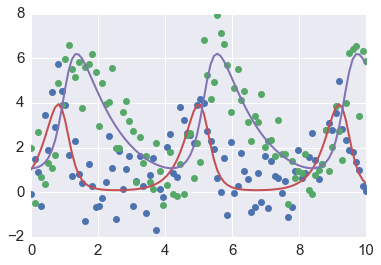

In [92]:
def f(xs, t, ps):
    """Lotka-Volterra predator-prey model."""
    try:
        a = ps['a'].value
        b = ps['b'].value
        c = ps['c'].value
        d = ps['d'].value
    except:
        a, b, c, d = ps
        
    x, y = xs
    return [a*x - b*x*y, c*x*y - d*y]

def g(t, x0, ps):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(f, x0, t, args=(ps,))
    return x

def residual(ps, ts, data):
    x0 = ps['x0'].value, ps['y0'].value
    model = g(ts, x0, ps)
    return (model - data).ravel()

t = np.linspace(0, 10, 100)
x0 = np.array([1,1])

a, b, c, d = 3,1,1,1
true_params = np.array((a, b, c, d))

np.random.seed(123)
data = g(t, x0, true_params)
data += np.random.normal(size=data.shape)

# set parameters incluing bounds
params = Parameters()
params.add('x0', value= float(data[0, 0]), min=0, max=10)  
params.add('y0', value=float(data[0, 1]), min=0, max=10)  
params.add('a', value=2.0, min=0, max=10)
params.add('b', value=2.0, min=0, max=10)
params.add('c', value=2.0, min=0, max=10)
params.add('d', value=2.0, min=0, max=10)

# fit model and find predicted values
result = minimize(residual, params, args=(t, data), method='leastsq')
final = data + result.residual.reshape(data.shape)

# plot data and fitted curves
plt.plot(t, data, 'o')
plt.plot(t, final, '-', linewidth=2);

# display fitted statistics
report_fit(result)

#### Optimization of graph node placement

To show the many different applications of optimization, here is an example using optimization to change the layout of nodes of a graph. We use a physical analogy - nodes are connected by springs, and the springs resist deformation from their natural length $l_{ij}$. Some nodes are pinned to their initial locations while others are free to move. Because the initial configuration of nodes does not have springs at their natural length, there is tension resulting in a high potential energy $U$, given by the physics formula shown below. Optimization finds the configuration of lowest potential energy given that some nodes are fixed (set up as boundary constraints on the positions of the nodes).

$$
U = \frac{1}{2}\sum_{i,j=1}^n ka_{ij}\left(||p_i - p_j||-l_{ij}\right)^2
$$

Note that the ordination algorithm Multi-Dimensional Scaling (MDS) works on a very similar idea - take a high dimensional data set in $\mathbb{R}^n$, and project down to a lower dimension ($\mathbb{R}^k$) such that the sum of distances $d_n(x_i, x_j) - d_k(x_i, x_j)$, where $d_n$ and $d_k$ are some measure of distance between two points $x_i$ and $x_j$ in $n$ and $d$ dimension respectively, is minimized. MDS is often used in exploratory analysis of high-dimensional data to get some intuitive understanding of its "structure".

In [93]:
from scipy.spatial.distance import pdist, squareform

- P0 is the initial location of nodes
- P is the minimal energy location of nodes given constraints
- A is a connectivity matrix - there is a spring between $i$ and $j$ if $A_{ij} = 1$
- $L_{ij}$ is the resting length of the spring connecting $i$ and $j$
- In addition, there are a number of `fixed` nodes whose positions are pinned.

In [94]:
n = 20
k = 1 # spring stiffness
P0 = np.random.uniform(0, 5, (n,2)) 
A = np.ones((n, n))
A[np.tril_indices_from(A)] = 0
L = A.copy()

In [95]:
def energy(P):
    P = P.reshape((-1, 2))
    D = squareform(pdist(P))
    return 0.5*(k * A * (D - L)**2).sum()

In [96]:
energy(P0.ravel())

In [97]:
# fix the position of the first few nodes just to show constraints
fixed = 4
bounds = (np.repeat(P0[:fixed,:].ravel(), 2).reshape((-1,2)).tolist() + 
          [[None, None]] * (2*(n-fixed)))
bounds[:fixed*2+4]

[[1.191249528562059, 1.191249528562059],
 [4.0389554314507805, 4.0389554314507805],
 [4.474891439430058, 4.474891439430058],
 [0.216114460398234, 0.216114460398234],
 [1.5097341813135952, 1.5097341813135952],
 [4.902910992971438, 4.902910992971438],
 [2.6975241127686767, 2.6975241127686767],
 [3.1315468085492815, 3.1315468085492815],
 [None, None],
 [None, None],
 [None, None],
 [None, None]]

In [98]:
sol = opt.minimize(energy, P0.ravel(), bounds=bounds)

#### Visualization

Original placement is BLUE
Optimized arrangement is RED.

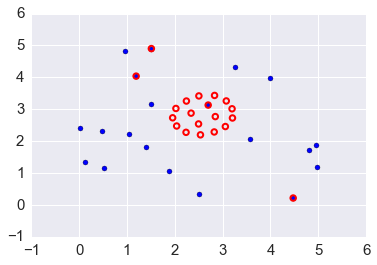

In [99]:
plt.scatter(P0[:, 0], P0[:, 1], s=25)
P = sol.x.reshape((-1,2))
plt.scatter(P[:, 0], P[:, 1], edgecolors='red', facecolors='none', s=30, linewidth=2);

Optimization of standard statistical models
---

When we solve standard statistical problems, an optimization procedure similar to the ones discussed here is performed. For example, consider multivariate logistic regression - typically, a Newton-like algorithm known as iteratively reweighted least squares (IRLS) is used to find the maximum likelihood estimate for the generalized linear model family. However, using one of the multivariate scalar minimization methods shown above will also work, for example, the BFGS minimization algorithm. 

The take home message is that there is nothing magic going on when Python or R fits a statistical model using a formula - all that is happening is that the objective function is set to be the negative of the log likelihood, and the minimum found using some first or second order optimization algorithm.

In [100]:
import statsmodels.api as sm

### Logistic regression as optimization

Suppose we have a binary outcome measure $Y \in {0,1}$ that is conditinal on some input variable (vector) $x \in (-\infty, +\infty)$. Let the conditioanl probability be $p(x) = P(Y=y | X=x)$. Given some data, one simple probability model is $p(x) = \beta_0 + x\cdot\beta$ - i.e. linear regression. This doesn't really work for the obvious reason that $p(x)$ must be between 0 and 1 as $x$ ranges across the real line. One simple way to fix this is to use the transformation $g(x) = \frac{p(x)}{1 - p(x)} = \beta_0 + x.\beta$. Solving for $p$, we get
$$
p(x) = \frac{1}{1 + e^{-(\beta_0 + x\cdot\beta)}}
$$
As you all know very well, this is logistic regression.

Suppose we have $n$ data points $(x_i, y_i)$ where $x_i$ is a vector of features and $y_i$ is an observed class (0 or 1). For each event, we either have "success" ($y = 1$) or "failure" ($Y = 0$), so the likelihood looks like the product of Bernoulli random variables. According to the logistic model, the probability of success is $p(x_i)$ if $y_i = 1$ and $1-p(x_i)$ if $y_i = 0$. So the likelihood is
$$
L(\beta_0, \beta) = \prod_{i=1}^n p(x_i)^y(1-p(x_i))^{1-y}
$$
and the log-likelihood is 
\begin{align}
l(\beta_0, \beta) &= \sum_{i=1}^{n} y_i \log{p(x_i)} + (1-y_i)\log{1-p(x_i)} \\
&= \sum_{i=1}^{n} \log{1-p(x_i)} + \sum_{i=1}^{n} y_i \log{\frac{p(x_i)}{1-p(x_i)}} \\
&= \sum_{i=1}^{n} -\log 1 + e^{\beta_0 + x_i\cdot\beta} + \sum_{i=1}^{n} y_i(\beta_0 + x_i\cdot\beta)
\end{align}

Using the standard 'trick', if we augment the matrix $X$ with a column of 1s, we can write $\beta_0 + x_i\cdot\beta$ as just $X\beta$.

In [101]:
df_ = pd.read_csv("http://www.ats.ucla.edu/stat/data/binary.csv")
df_.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [102]:
# We will ignore the rank categorical value

cols_to_keep = ['admit', 'gre', 'gpa']
df = df_[cols_to_keep]
df.insert(1, 'dummy', 1)
df.head()

,admit,dummy,gre,gpa
0,0,1,380,3.61
1,1,1,660,3.67
2,1,1,800,4.00
3,1,1,640,3.19
4,0,1,520,2.93


### Solving as a GLM with IRLS

This is very similar to what you would do in R, only using Python's `statsmodels` package. The GLM solver uses a special variant of Newton's method known as iteratively reweighted least squares (IRLS), which will be further desribed in the lecture on multivarite and constrained optimizaiton.

In [103]:
model = sm.GLM.from_formula('admit ~ gre + gpa', 
                            data=df, family=sm.families.Binomial())
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  admit   No. Observations:                  400
Model:                            GLM   Df Residuals:                      397
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -240.17
Date:                Thu, 18 Feb 2016   Deviance:                       480.34
Time:                        15:23:26   Pearson chi2:                     398.
No. Iterations:                     6                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -4.9494      1.075     -4.604      0.000        -7.057    -2.842
gre            0.0027      0.001      2.544      0.011         0.001     0.005
gpa            0.7547      0.320      2.361      0.018         0.128     1.381
==============================================================================
"""

### Solving as logistic model with bfgs

Note that you can choose any of the scipy.optimize algotihms to fit the maximum likelihood model. This knows about higher order derivatives, so will be more accurate than homebrew version.

In [104]:
model2 = sm.Logit.from_formula('admit ~ %s' % '+'.join(df.columns[2:]), data=df)
fit2 = model2.fit(method='bfgs', maxiter=100)
fit2.summary()

Optimization terminated successfully.
         Current function value: 0.600430
         Iterations: 23
         Function evaluations: 65
         Gradient evaluations: 54


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      397
Method:                           MLE   Df Model:                            2
Date:                Thu, 18 Feb 2016   Pseudo R-squ.:                 0.03927
Time:                        15:23:26   Log-Likelihood:                -240.17
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 5.456e-05
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -4.9494      1.075     -4.604      0.000        -7.057    -2.842
gre            0.0027      0.001      2.544      0.011         0.001     0.005
gpa            0.7547      0.320      2.361      0.018         0.128     1.381
==============================================================================
"""

### Home-brew logistic regression using a generic minimization function

This is to show that there is no magic going on - you can write the function to minimize directly from the log-likelihood equation and run a minimizer. It will be more accurate if you also provide the derivative (+/- the Hessian for second order methods), but using just the function and numerical approximations to the derivative will also work. As usual, this is for illustration so you understand what is going on - when there is a library function available, youu should probably use that instead.

In [105]:
def f(beta, y, x):
    """Minus log likelihood function for logistic regression."""
    return -((-np.log(1 + np.exp(np.dot(x, beta)))).sum() + (y*(np.dot(x, beta))).sum())

In [106]:
beta0 = np.zeros(3)
opt.minimize(f, beta0, args=(df['admit'], df.ix[:, 'dummy':]), method='BFGS', options={'gtol':1e-2})

     nfev: 80
 hess_inv: array([[  1.15242936e+00,  -2.77649429e-04,  -2.81644777e-01],
       [ -2.77649429e-04,   1.16649722e-06,  -1.22069519e-04],
       [ -2.81644777e-01,  -1.22069519e-04,   1.02628000e-01]])
      fun: 240.17199089493948
      nit: 8
     njev: 16
  success: True
   status: 0
  message: 'Optimization terminated successfully.'
        x: array([ -4.94933570e+00,   2.69034401e-03,   7.54734491e-01])
      jac: array([  9.15527344e-05,  -1.96456909e-03,   4.59671021e-04])

### Optimization with `sklearn`

There are also many optimization routines in the `scikit-learn` package, as you already know from the previous lectures. Many machine learning problems essentially boil down to the minimization of some appropriate loss function.

### Resources

- [Scipy Optimize refernce](http://docs.scipy.org/doc/scipy/reference/optimize.html)
- [Scipy Optimize tutorial](http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)
- [LMFit - a modeling interface for nonlinear least squares problems](http://cars9.uchicago.edu/software/python/lmfit/index.html)
- [CVXpy- a modeling interface for convex optimization problems](https://github.com/cvxgrp/cvxpy)
- [Quasi-Newton methods](http://en.wikipedia.org/wiki/Quasi-Newton_method)
- [Convex optimization book by Boyd & Vandenberghe](http://stanford.edu/~boyd/cvxbook/)
- [Nocedal and Wright textbook](http://www.springer.com/us/book/9780387303031)

In [107]:
%load_ext version_information
%version_information scipy, statsmodels, sympy, lmfit

Software versions
Python 3.5.1 64bit [GCC 4.2.1 (Apple Inc. build 5577)]
IPython 4.0.1
OS Darwin 15.3.0 x86_64 i386 64bit
scipy 0.16.1
statsmodels 0.6.1
sympy 0.7.6.1
lmfit 0.9.2
Thu Feb 18 15:23:26 2016 EST